# Objetivo

Encontrar agrupamentos nos textos dos bots que não se refiram unicamente aos assuntos abordados, mas que dêem uma dimensão diferente (tom de voz, tipo de texto de forma geral)

Para isso será testada a vetorização de palavras com o algoritmo word2vec para trazer uma maior qualidade semântica

## Query mensagens

In [1]:
import pandas as pd
import numpy as np
import os as os
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.util import ngrams
import acessos as ac
from arabica import arabica_freq
from unidecode import unidecode
import re
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
query = """

select 
msg.id_issue
, msg.dt_envio_mensagem
, nm_entidade
, msg.ds_message
, novas_tags.hierarquia_4
, novas_tags.fila_de_atendimento
from cx_curated_zone.helpshift_issues_messages msg
left join "cx_curated_zone"."helpshift_issues" AS issues_macro ON msg."id_issue" = issues_macro."id_issue"
left join "cx_curated_zone"."helpshift_tag_niveis" AS helpshift_tag ON msg."id_issue" = helpshift_tag."id_issue"
left join processed_zone_api_cxm_tags.tags_hierarquia_gerencial as novas_tags ON trim(lower(n3)) = trim(lower(nm_tag_n3))
where ds_entidade = 'bot'
and dt_envio_mensagem >= to_date('2022-06-01','yyyy-mm-dd')
order by rand() desc
limit 50000

"""

df = ac.df_athena('flavia-costa', query)

## Funções de tratamento

In [3]:
def replace_unuseful_messages(text):
    '''
    Replace automatic and irrelevant (for the project purpose) messages with empty string
    '''
    unuseful_messages = [
        'Outros assuntos',
        'Quero falar de outra coisa',
        'Quero resolver uma coisa',
        'Falar com atendente',
        '&Eacute; outra coisa',
        '&Eacute; outro assunto',
        'Voltar pro come&ccedil;o',
        '&Eacute; outro motivo',
        'Quero falar com atendente',
        'Me mostra as op&ccedil;&otilde;es de antes',
        'Quero falar de outro assunto',
        '&Eacute; outro assunto',
        '&Eacute; outra coisa ',
        'N&atilde;o, ainda tenho d&uacute;vidas',
        'Nenhuma das op&ccedil;&otilde;es',
        'Falar de outra coisa',
        'Quero voltar pro come&ccedil;o',
        'Voltar pro come&ccedil;o',
        'Falar com atendente',
        'Pode sim Por favor',
        'Não, ainda tenho dúvidas',
        'Certo',
        'Obrigado',
        'Responde'
    ]

    if text.strip() in unuseful_messages:
        return ''

    return text

In [4]:
def remove_emoji(text):
    '''
    Replace emojis with empty string
    '''
    regrex_pattern = re.compile(pattern="["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                "]+", flags=re.UNICODE)
    return regrex_pattern.sub(r'', str(text))

In [5]:
def clean_text(x):
    x = x.strip()
    x = x.lower()
    x = unidecode(x)
    x = re.sub(r'\t', ' ', x)
    x = re.sub(r'http\S+', '', x)  # remove url
    x = re.sub(r'screenshot sent', 'screenshotsent', x)
    x = re.sub(r'will bank', 'willbank', x)
    x = re.sub(r'(nbsp\;|[rl]dquo\;|quot\;|acute\;|tilde\;|circ\;|grave\;|cedil\;|\&|\/)', '', x)  # replace special characters
    
    x = x.replace('&ccedil;','ç')
    x = x.replace('&atilde;;','ã')
    x = x.replace('&otilde;;','õ')
    x = re.sub(r'(\d{1,}|\!|\?|\,|\.|\\n|\:|\;|\`|\´|\-|\_)', ' ', x)  # replace punctuation and remove numbers
    x = x.replace('  ',' ')
    x = x.replace('\n','')
    x = x.strip()
    return x

In [6]:
def retira_saudacoes(text):
       
   regex_list = [
        'bo[ma] (dia|tarde|noite)',
        'agradeco', 'agradecido',
        '(tu?do?|esta|tah?) (b[eo]m|cert(inh)?[oa]|ok)',
        'ok', 'okay', 'sim',
        'oi{1,}e{0,}', 'ola', 'opa',
        'beleza', 'blz',
        'compreendi(do)?',
        'entendi(do)?',
        'tendi(do)?',
        '(muito|mt)? ?(obrigad[oa]|obg|b[oe]m)',
        'b?a{1,10}h?',
        'abracos?',
        '(por|de) na?da?',
        'por (favor|gentileza)'
    ]
   
   regex_list += stopwords
   pattern = r'\b(' + '|'.join(regex_list) + r')\b'
   text = re.sub(pattern, '', str(text))
   text = text.replace('  ',' ')
   return text

In [7]:
stopwords= ['não','nao',  'da', 'em', 'você', 'de', 'ao', 'os', 'que', 'e', 'eu', 'o', 'estou', 'ele','ela','pra', 'pro', 'entao', 'para', 'voce', 'cartao', 'limite',
            'seu', 'sua', 'por', 'sobre', 'mais', 'uma', 'um',
            'fatura', 'faturas', 'ta', 'to', 'ai', 'la', 'lo', 'lhe', 'ne','pra', 'tá', 'né', 'ah', 'aí', 'dá', 'ó', 'mim', 'então', 'aqui', 'tô', 'pro', 'isso']

## Tratando texto da mensagem

In [8]:
df['ds_message_tratada'] = df['ds_message'].apply(replace_unuseful_messages)
df['ds_message_tratada'] = df['ds_message_tratada'].apply(remove_emoji)
df['ds_message_tratada'] = df['ds_message_tratada'].apply(clean_text)
df['ds_message_tratada'] = df['ds_message_tratada'].apply(retira_saudacoes)

## substituindo endereços pela palavra 'endereço'
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("rua"), 'endereço', df['ds_message_tratada'])
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("cep"), 'endereço', df['ds_message_tratada'])

## substituindo links pela palavra 'url'
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("https"), 'url', df['ds_message_tratada'])

## Substituido todos os códigos pela palavra 'código' - os código encontrados continham wi5, wi9, wi8, yf ou bc
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("wi5"), 'código', df['ds_message_tratada'])
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("wi9"), 'código', df['ds_message_tratada'])
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("wi8"), 'código', df['ds_message_tratada'])
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("bc"), 'código', df['ds_message_tratada'])
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("yf"), 'código', df['ds_message_tratada'])
##Tratando algumas palavras
df['ds_message_tratada'] = df['ds_message_tratada'].str.replace('ª', '')
df['ds_message_tratada'] = df['ds_message_tratada'].str.replace('º', '')
df['ds_message_tratada'] = df['ds_message_tratada'].str.replace(' r ', ' ')

## protocolo / ate dias / voce pode 
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("protocolo"), '', df['ds_message_tratada'])
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("ate dias"), '', df['ds_message_tratada'])
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("voce pode"), '', df['ds_message_tratada'])

df['ds_message_tratada'] = df['ds_message_tratada'].apply(clean_text)
df_clean = df.query('ds_message_tratada != " "').query('ds_message_tratada != "  "').query('ds_message_tratada != ""').query('ds_message_tratada != "   "')

## Gerando n-grams pelo pacote arabica

In [12]:
df_agg_ungroup_tmp = arabica_freq(
                text = df_clean['ds_message_tratada'],
                time = df_clean['dt_envio_mensagem'],
                time_freq = 'ungroup',           # opção ungroup
                max_words = 30,             
                stopwords = ['portuguese'],   
                skip = [stopwords],         
                numbers = True,            
                punct = True,              
                lower_case = True)

df_agg_ungroup_tmp.head(40)

,unigram,unigram_freq,bigram,bigram_freq,trigram,trigram_freq
0,escolhe,7018,"certo,estao",4144,"certo,estao,assuntos",4144
1,certo,6345,"estao,assuntos",4144,"estao,assuntos,procurados",4144
2,assuntos,6100,"assuntos,procurados",4144,"assuntos,procurados,escolhe",4144
3,ja,5906,"procurados,escolhe",4144,"alguns,assuntos,escolhe",1817
4,estao,4199,"ja,chamo",3298,"trouxe,alguns,assuntos",1817
5,duvida,4197,"duvida,assunto",2320,"usufruir,beneficios,pag",1781
6,procurados,4144,"tambem,opcoes",1962,"principalmente,continuar,oportunidade",1781
7,will,4068,"pessoa,equipe",1855,"continuar,oportunidade,usufruir",1781
8,opcoes,3790,"alguns,assuntos",1817,"saber,detalhes,dessa",1781
9,pag,3569,"assuntos,escolhe",1817,"oportunidade,usufruir,beneficios",1781


# Modelo word2vec

In [ ]:
#!pip install gensim

- Como podemos validar frases do bot similares?


Ja identificamos alguns tipos de mensagens pelos n-grams:

- Instrutivo: 
"acesse a home":  "va ate o menu" - "entre na central pix"

- Novidade: 
"ja esta sabendo da novidade" - "vou te contar uma novidade" - "detalhes dessa novidade"

- Opçoes (Escolha): 
"escolha uma opcao" - "escolha os assuntos procurados" - "alguma dessas opcoes"

- Migração: 
"pag agora e will" - "pag ja esta sabendo"


- Ajuda / Encaminhar atendimento: 
"ja chamo alguem pra te ajudar" - "vou chamar alguem" - "chamar uma pessoa da equipe"

- Prazo: 
"ate dias uteis" - "o prazo e"


- Informa instabilidade: 
"o sistema esta instavel" / "houve uma instabilidade"


In [11]:
from tqdm import tqdm
from gensim.models import Doc2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk.data
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/flavia.costa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import re
import gensim
import itertools
import pandas as pd
from gensim.models import TfidfModel
from gensim.similarities import MatrixSimilarity
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.parsing.preprocessing import preprocess_documents
from gensim.parsing.preprocessing import preprocess_string

In [26]:
w2v_total_data = list(df_clean['ds_message_tratada'].unique())

### primeiro teste

In [90]:
def build_model(max_epochs, hs, dm, vec_size, window, alpha, text):
    
    train_text = [TaggedDocument(words=str(s).lower().split(), tags=[i]) for i, s in enumerate(text)]

    model = Doc2Vec(vector_size = vec_size,
                 hs = hs #hierarquical softmax
               , dm = dm
               , dm_concat = 0
               , dbow_words = 1
               , window = window
               , alpha= alpha
               , min_alpha= 0.00025
               , min_count= 1
               )
    
    model.build_vocab(train_text)
    
    # With the model built we simply train on the data.
    
    for epoch in range(max_epochs):
        #print(f"Iteration {epoch}")
        model.train(train_text,
                   total_examples=model.corpus_count,
                   epochs=model.epochs)

    return model

In [110]:
model = build_model(max_epochs=10, hs =0, dm = 1, vec_size=200, window = 1, alpha=0.03, text = w2v_total_data)

In [111]:
model.wv.similarity('escolha', 'opcoes')

0.17366087

### tunning do modelo

In [126]:
def tunning_doc2vec():
  
  dm = [1, 0]
  vector_size = [10, 20, 50, 70, 100, 150, 200]
  window = [1, 2, 3, 4, 5]
  hs = [1, 0]


  paramsList = [{'dm': item[0],
                'vector_size': item[1],
                'window': item[2],
                'hs': item[3]
                } for item in
                  list(itertools.product(*[dm,
                                            vector_size,
                                            window,
                                            hs]))
                ]

  score_model_final = pd.DataFrame([], columns=['hs', 'dm', 'vector_size','window','score'])

  for params in paramsList:
    score_model_tmp = pd.DataFrame()
    model = build_model(max_epochs=10, hs =params['hs'], dm = params['dm'], vec_size=params['vector_size'], window = params['window'], alpha=0.03, text = w2v_total_data)
    
    score_model_tmp = pd.DataFrame({'hs': params['hs'], 'dm': params['dm'], 'vector_size': params['vector_size'], 'window': params['window']}, index=[0])
    
    '''
    key = ['escolha', 'acesse', 'chamar', 'dias', 'instavel', 'novidade']
    match1 = ['opcoes', 'entre', 'ajudar', 'uteis', 'instabilidade', 'sabendo']
    match2 = ['assuntos', 'va', 'equipe', 'prazo', 'demora', 'contar']
       
    '''   
    print(params)
       
    
    score = model.wv.similarity('escolha', 'opcoes') + model.wv.similarity('escolha', 'assuntos')  
    + model.wv.similarity('acesse', 'acessar') + model.wv.similarity('chamar', 'ajudar') + model.wv.similarity('chamar', 'equipe')
    + model.wv.similarity('dias', 'uteis') + model.wv.similarity('dias', 'prazo')  + model.wv.similarity('instavel', 'instabilidade')
    + model.wv.similarity('instavel', 'demora') + model.wv.similarity('novidade', 'sabendo')  + model.wv.similarity('novidade', 'contar')
    
    
    score_model_tmp['score'] = score
       
    print(score)
    
    #for i in key:
      #try:    
    #  score_model_tmp['score'] =+ model.wv.similarity(i, match1.index(i))
    #  score_model_tmp['score'] =+ model.wv.similarity(i, match2.index(i))
      
      #except:
      #  pass
      
    
    score_model_final = score_model_final.append(score_model_tmp)

  return score_model_final
 

In [128]:
model_scores = tunning_doc2vec()

{'dm': 1, 'vector_size': 10, 'window': 1, 'hs': 1}
0.50991327
{'dm': 1, 'vector_size': 10, 'window': 1, 'hs': 0}
0.6430634
{'dm': 1, 'vector_size': 10, 'window': 2, 'hs': 1}
-0.30949366
{'dm': 1, 'vector_size': 10, 'window': 2, 'hs': 0}
0.3804766
{'dm': 1, 'vector_size': 10, 'window': 3, 'hs': 1}
-0.08062551
{'dm': 1, 'vector_size': 10, 'window': 3, 'hs': 0}
0.7454176
{'dm': 1, 'vector_size': 10, 'window': 4, 'hs': 1}
-0.037918746
{'dm': 1, 'vector_size': 10, 'window': 4, 'hs': 0}
0.4712971
{'dm': 1, 'vector_size': 10, 'window': 5, 'hs': 1}
-0.19089553
{'dm': 1, 'vector_size': 10, 'window': 5, 'hs': 0}
0.6074151
{'dm': 1, 'vector_size': 20, 'window': 1, 'hs': 1}
-0.52708256
{'dm': 1, 'vector_size': 20, 'window': 1, 'hs': 0}
0.5710952
{'dm': 1, 'vector_size': 20, 'window': 2, 'hs': 1}
-0.32808572
{'dm': 1, 'vector_size': 20, 'window': 2, 'hs': 0}
0.4957438
{'dm': 1, 'vector_size': 20, 'window': 3, 'hs': 1}
-0.43798262
{'dm': 1, 'vector_size': 20, 'window': 3, 'hs': 0}
0.69265497
{'dm': 

In [129]:
model_scores.sort_values(by = 'score', ascending=False).head()

,hs,dm,vector_size,window,score
0,0,0,10,4,1.079702
0,0,0,10,3,0.952798
0,0,0,10,2,0.854025
0,0,0,10,5,0.849815
0,0,1,20,5,0.839968


## Modelo final doc2vec - após tunning

In [130]:
model = build_model(max_epochs=50, hs =0, dm = 0, vec_size=10, window = 4, alpha=0.03, text = w2v_total_data)

### Extraindo vetores numericos do modelo

In [131]:
vetorDoc = model.wv.vectors

### Redução de dimensionalidade do vetor

In [132]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95) #Explicar 95% da variância
pca.fit(vetorDoc)
vetorDoc_pca = pca.transform(vetorDoc)

componentes = vetorDoc_pca.shape[1]
print(componentes)

9


### Visualização dos vetores em 2d

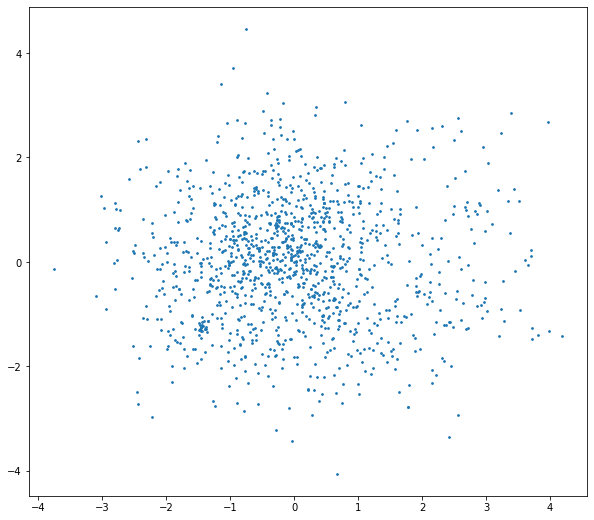

In [133]:
cluster_embedding = vetorDoc_pca
plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

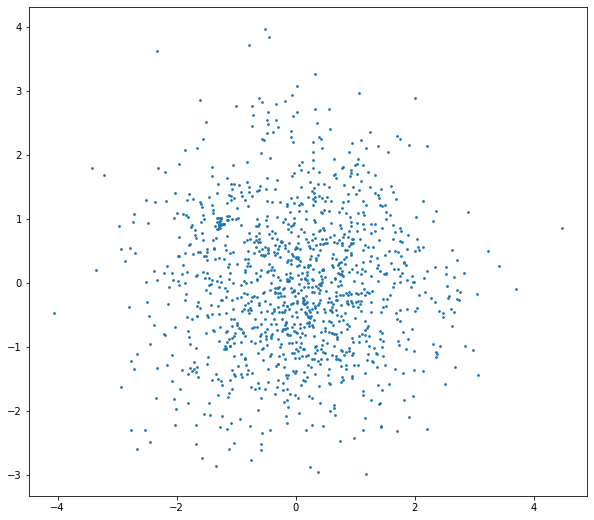

In [134]:
plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 1], cluster_embedding[:, 3], s=3, cmap='Spectral')

# Clusterização dos vetores

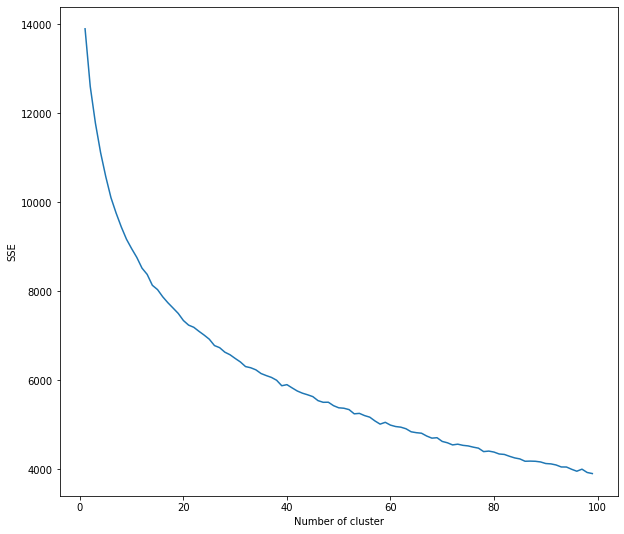

In [135]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = {}
for k in range(1, 100):
    kmeans = KMeans(n_clusters=k, max_iter=500).fit(cluster_embedding)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

plt.figure(figsize=(10,9))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

## Cluster k-means

In [136]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=50).fit(cluster_embedding)
cluster = kmeans.predict(cluster_embedding)

## Cluster hierarquico com redução

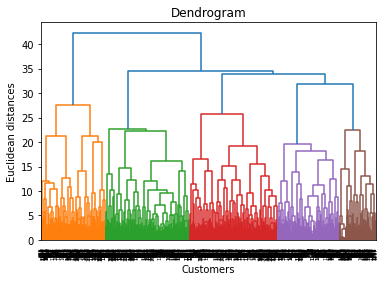

In [137]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(cluster_embedding, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

In [138]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 50, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(cluster_embedding)

In [139]:
df_cluster = pd.DataFrame(list(zip(cluster, w2v_total_data, y_hc)), 
               columns =['cluster', 'vocabulo', 'cluster_hie'])
df_cluster.head()

,cluster,vocabulo,cluster_hie
0,31,certo vi atrasada normal acontece,21
1,31,certo estao assuntos procurados escolhe deles,21
2,31,ter com gente,21
3,31,certo veja se dessas opcoes precisa saber,21
4,31,duvida qual assunto,2


In [140]:
df_cluster['cluster'].value_counts()

31    63
25    32
16    28
42    25
1     22
23    21
36    18
9     17
41    17
12    17
0     17
27    17
18    17
13    17
7     16
2     16
34    15
22    15
46    15
48    15
11    14
44    14
8     13
47    13
5     13
49    13
3     12
45    12
15    12
10    11
6     11
17    11
24    10
20    10
35     9
37     9
4      8
29     8
21     8
26     7
19     7
43     7
14     7
40     7
30     6
39     4
33     2
32     2
28     1
38     1
Name: cluster, dtype: int64

In [141]:
df_cluster['cluster_hie'].value_counts()

2     92
21    55
9     33
7     24
20    22
4     22
48    20
6     18
15    17
16    16
30    15
26    15
22    15
13    14
18    14
14    14
12    14
31    14
25    13
33    13
0     12
19    12
43    12
35    12
34    11
8     11
1     10
3     10
32    10
46    10
37     9
40     9
5      9
42     8
28     8
38     7
27     7
49     7
39     6
23     6
47     6
10     6
24     5
17     5
11     4
29     3
44     3
36     2
45     1
41     1
Name: cluster_hie, dtype: int64

## Função de n-grams por cluster - método k-means

In [142]:
df_cluster['dt_envio_mensagem'] = pd.to_datetime("2022-01-12")

In [143]:
def ranking_cluster(df_clean, cluster):
    
    df_agg_ungroup_final = pd.DataFrame([], columns=['unigram', 'unigram_freq',
                                                     'bigram','bigram_freq','trigram','trigram_freq', 'cluster'])
    
    for i in df_clean[cluster].unique():
        try:
            df_clean_tmp = df_clean[df_clean[cluster] == i ]
            df_agg_ungroup_tmp = arabica_freq(
                text = df_clean_tmp['vocabulo'],
                time = df_clean_tmp['dt_envio_mensagem'],
                time_freq = 'ungroup',           # opção ungroup
                max_words = 10,             
                stopwords = ['portuguese'],   
                skip = [stopwords],         
                numbers = True,            
                punct = True,              
                lower_case = True) 
            
            result_temp = pd.DataFrame({'unigram': df_agg_ungroup_tmp['unigram'], 'unigram_freq': df_agg_ungroup_tmp['unigram_freq'],
                                        'bigram': df_agg_ungroup_tmp['bigram'], 'bigram_freq': df_agg_ungroup_tmp['bigram_freq'],
                                        'trigram': df_agg_ungroup_tmp['trigram'], 'trigram_freq': df_agg_ungroup_tmp['trigram_freq']}, index=[0])
            
            result_temp['cluster'] = i
                    
            df_agg_ungroup_final = df_agg_ungroup_final.append(result_temp)

        except IndexError:
            pass
                
    return df_agg_ungroup_final

In [144]:
df_resumo = ranking_cluster(df_cluster, 'cluster')
df_resumo['unigram_freq'] = df_resumo['unigram_freq'].astype('int')
df_resumo['bigram_freq'] = df_resumo['bigram_freq'].astype('int')
df_resumo['trigram_freq'] = df_resumo['trigram_freq'].astype('int')
df_resumo['cluster'] = df_resumo['cluster'].astype('str')

df_resumo['unigram_h'] = df_resumo['cluster'] + ' : ' + df_resumo['unigram']
df_resumo['bigram_h'] = df_resumo['cluster'] + ' : ' + df_resumo['bigram']
df_resumo['trigram_h'] = df_resumo['cluster'] + ' : ' + df_resumo['trigram']

In [145]:
df_resumo.head(30)

,unigram,unigram_freq,bigram,bigram_freq,trigram,trigram_freq,cluster,unigram_h,bigram_h,trigram_h
0,compra,9,"valor,compra",4,"ainda,aumentar,will",2,31,31 : compra,"31 : valor,compra","31 : ainda,aumentar,will"
0,ja,6,"ja,chamo",4,"ja,chamo,alguem",3,25,25 : ja,"25 : ja,chamo","25 : ja,chamo,alguem"
0,r,5,"fase,r",3,"ordm,fase,r",3,2,2 : r,"2 : fase,r","2 : ordm,fase,r"
0,pode,4,"quer,saber",2,"deseja,fazer,parcelamento",1,13,13 : pode,"13 : quer,saber","13 : deseja,fazer,parcelamento"
0,r,6,"r,fase",3,"r,fase,r",3,42,42 : r,"42 : r,fase","42 : r,fase,r"
0,pagar,3,"acesse,menu",2,"oba,notei,acabou",1,18,18 : pagar,"18 : acesse,menu","18 : oba,notei,acabou"
0,saldo,2,"total,atraso",2,"saldo,atualizado,r",1,39,39 : saldo,"39 : total,atraso","39 : saldo,atualizado,r"
0,reconhece,1,"reconhece,todas",1,"reconhece,todas,transacoes",1,14,14 : reconhece,"14 : reconhece,todas","14 : reconhece,todas,transacoes"
0,parcelamento,3,"puder,realizar",1,"puder,realizar,pagamento",1,21,21 : parcelamento,"21 : puder,realizar","21 : puder,realizar,pagamento"
0,conta,3,"saldo,conta",2,"precisa,ajuda,alguma",1,12,12 : conta,"12 : saldo,conta","12 : precisa,ajuda,alguma"


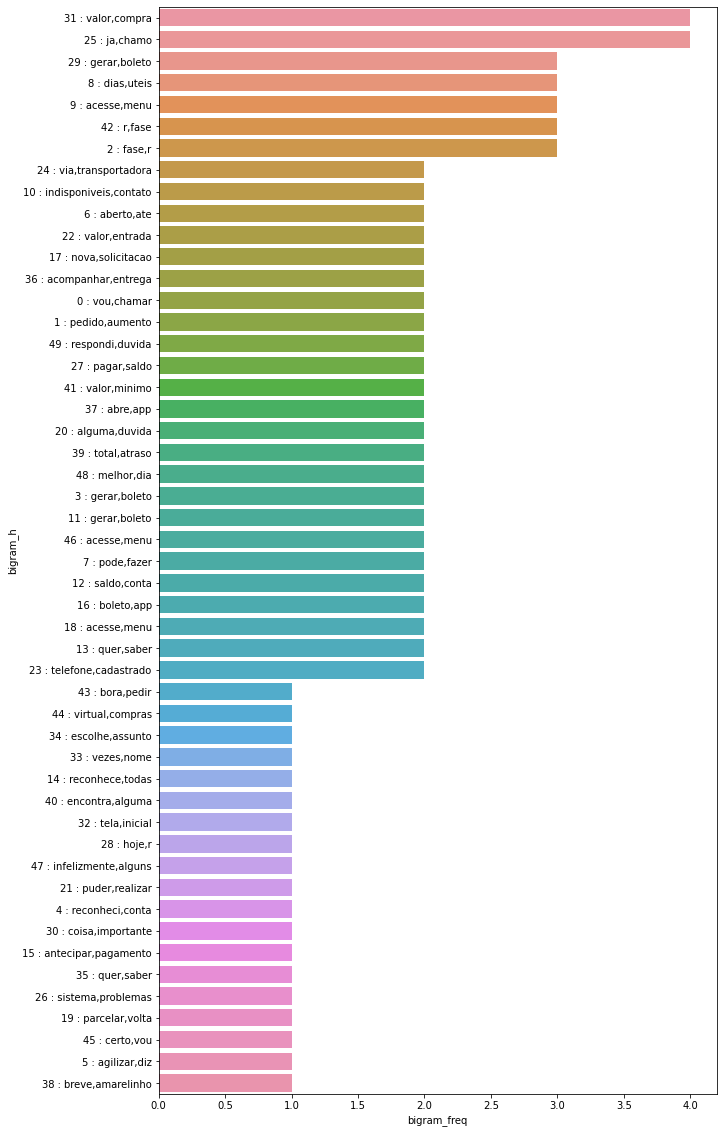

In [146]:
plt.figure(figsize=(10,20))
sns.barplot(data = df_resumo.sort_values(by ='bigram_freq', ascending=False), x = 'bigram_freq', y = 'bigram_h')
plt.show()

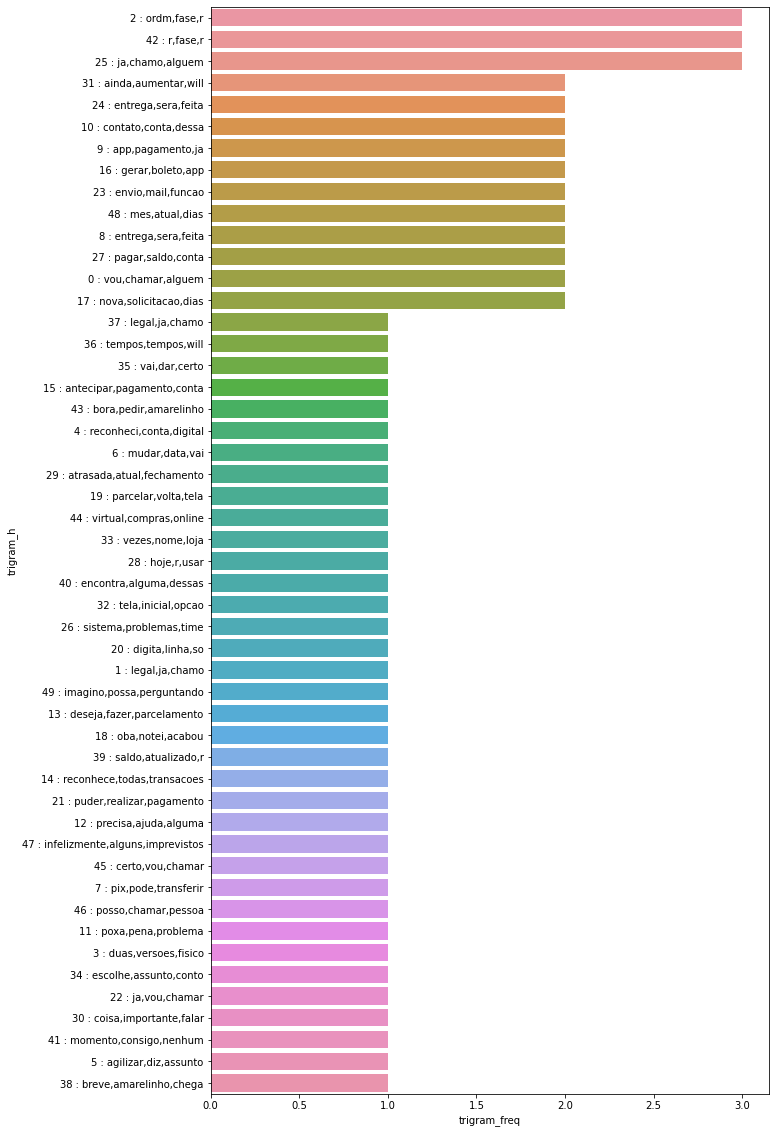

In [147]:
plt.figure(figsize=(10,20))
sns.barplot(data = df_resumo.sort_values(by ='trigram_freq', ascending=False), x = 'trigram_freq', y = 'trigram_h')
plt.show()

## Função de n-grams por cluster - método hierarquico

In [148]:
df_resumo = ranking_cluster(df_cluster, 'cluster_hie')
df_resumo['unigram_freq'] = df_resumo['unigram_freq'].astype('int')
df_resumo['bigram_freq'] = df_resumo['bigram_freq'].astype('int')
df_resumo['trigram_freq'] = df_resumo['trigram_freq'].astype('int')
df_resumo['cluster'] = df_resumo['cluster'].astype('str')

df_resumo['unigram_h'] = df_resumo['cluster'] + ' : ' + df_resumo['unigram']
df_resumo['bigram_h'] = df_resumo['cluster'] + ' : ' + df_resumo['bigram']
df_resumo['trigram_h'] = df_resumo['cluster'] + ' : ' + df_resumo['trigram']

In [149]:
df_resumo.head(30)

,unigram,unigram_freq,bigram,bigram_freq,trigram,trigram_freq,cluster,unigram_h,bigram_h,trigram_h
0,r,9,"r,fase",3,"r,fase,r",3,21,21 : r,"21 : r,fase","21 : r,fase,r"
0,pode,14,"acesse,menu",6,"ja,chamo,alguem",4,2,2 : pode,"2 : acesse,menu","2 : ja,chamo,alguem"
0,compra,5,"pedir,via",3,"volta,tela,inicial",2,7,7 : compra,"7 : pedir,via","7 : volta,tela,inicial"
0,opcao,4,"oba,notei",1,"oba,notei,acabou",1,26,26 : opcao,"26 : oba,notei","26 : oba,notei,acabou"
0,pode,5,"digita,codigo",2,"clica,desbloquear,digita",2,6,6 : pode,"6 : digita,codigo","6 : clica,desbloquear,digita"
0,antecipar,3,"acesse,menu",2,"puder,realizar,pagamento",1,10,10 : antecipar,"10 : acesse,menu","10 : puder,realizar,pagamento"
0,emergencial,4,"gerar,boleto",3,"dias,uteis,dia",2,22,22 : emergencial,"22 : gerar,boleto","22 : dias,uteis,dia"
0,ja,4,"infelizmente,alguns",1,"infelizmente,alguns,imprevistos",1,48,48 : ja,"48 : infelizmente,alguns","48 : infelizmente,alguns,imprevistos"
0,ja,2,"ja,chamo",1,"ja,chamo,alguem",1,35,35 : ja,"35 : ja,chamo","35 : ja,chamo,alguem"
0,r,6,"ordm,fase",3,"r,ordm,fase",3,9,9 : r,"9 : ordm,fase","9 : r,ordm,fase"


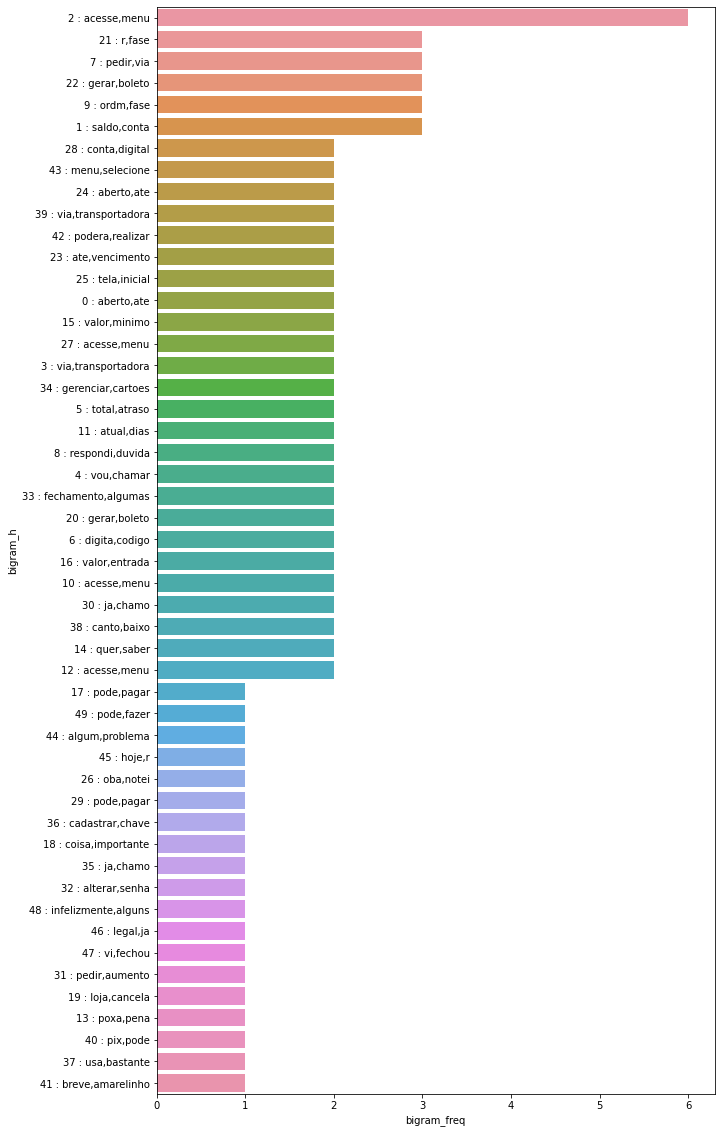

In [150]:
plt.figure(figsize=(10,20))
sns.barplot(data = df_resumo.sort_values(by ='bigram_freq', ascending=False), x = 'bigram_freq', y = 'bigram_h')
plt.show()

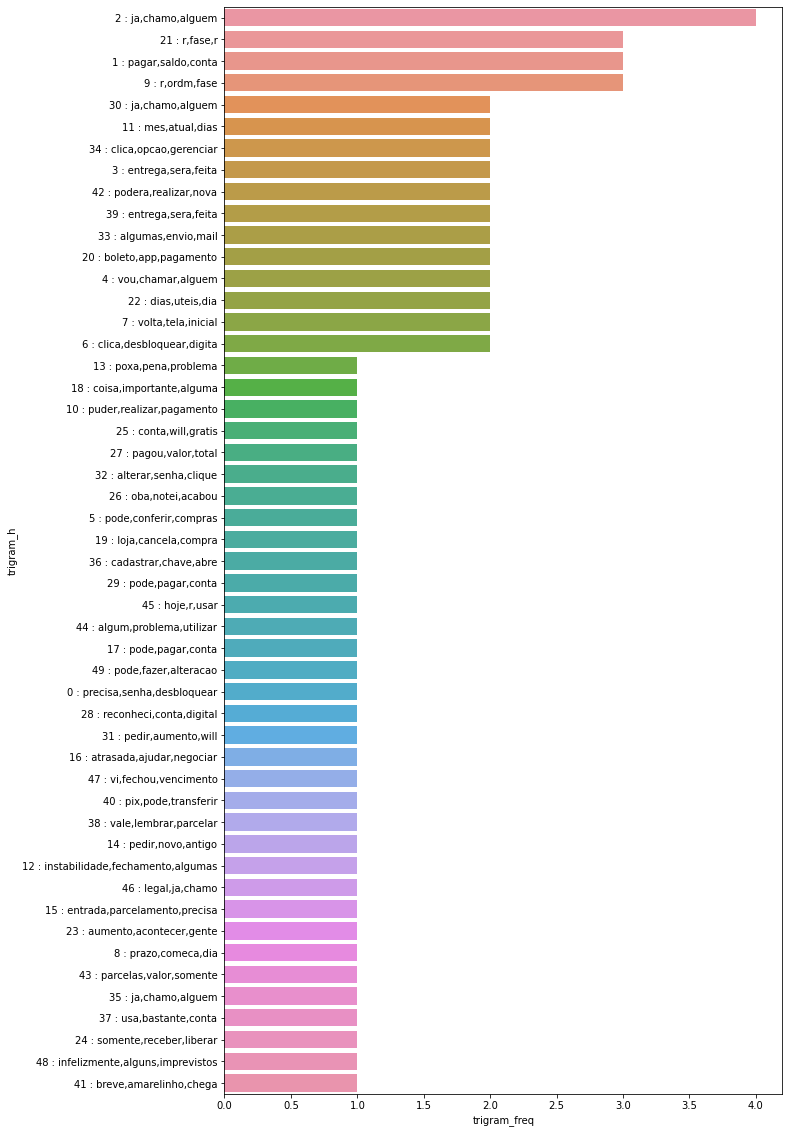

In [151]:
plt.figure(figsize=(10,20))
sns.barplot(data = df_resumo.sort_values(by ='trigram_freq', ascending=False), x = 'trigram_freq', y = 'trigram_h')
plt.show()

Tom de comunicação:
- Instrutivo
- Informar Novidade
- Oportunidade
- Opçoes (Escolha)
- Migração
- Ajuda / Encaminhar atendimento 
- Informar Prazo
- Informa instabilidade


## Clusterização com tfidf pacote text hero  + K-means

In [9]:
import texthero as hero

df_clean['pca'] = (
   df_clean['ds_message_tratada']
   .pipe(hero.clean)
   .pipe(hero.tfidf)
   .pipe(hero.pca)
)

df_clean['pca_1'] = df_clean['pca'].astype('string').str.split(",").str[1]
df_clean['pca_2'] = df_clean['pca'].astype('string').str.split(",").str[0]

for i in ['pca_1','pca_2']:
    df_clean[i] = df_clean[i].str.replace(']','').str.replace('[','').astype("float")


In [14]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15).fit(df_clean[['pca_1','pca_2']])
cluster = kmeans.predict(df_clean[['pca_1','pca_2']])

df_clean['cluster_hero'] = cluster

### Contagem do novo cluster

In [15]:
df_clean['cluster_hero'].value_counts()

0     13505
11     6434
3      5057
1      4123
7      2667
2      2306
4      1730
8      1573
6      1468
13      908
10      658
5       624
9       566
14      401
12      196
Name: cluster_hero, dtype: int64

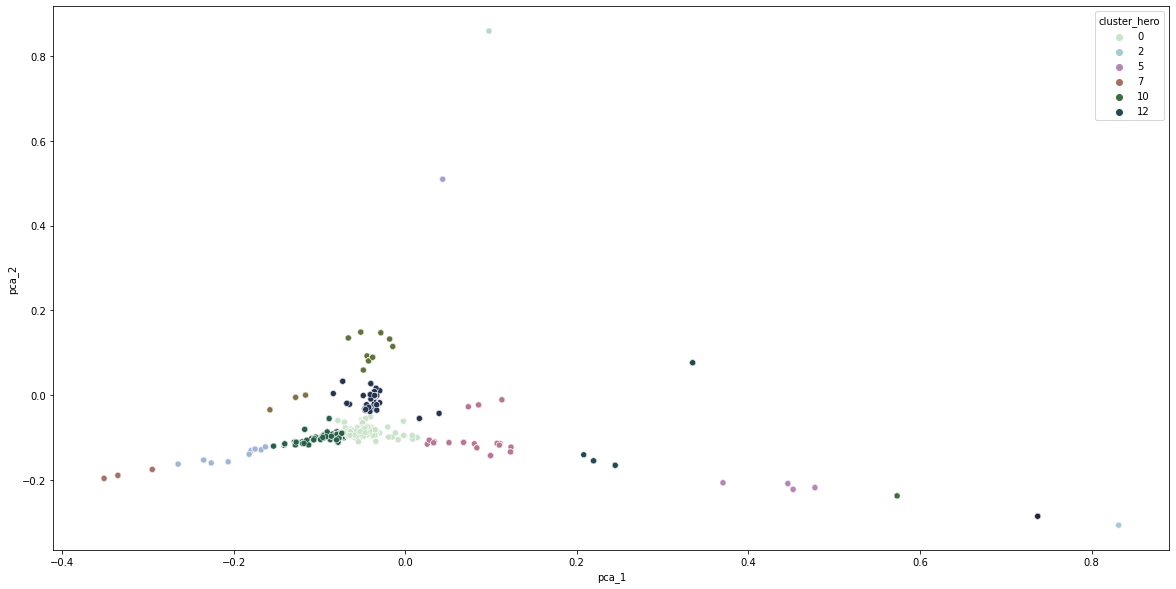

In [17]:
plt.figure(figsize=(20,10))
sns.scatterplot(data = df_clean, x = 'pca_1', y = 'pca_2', hue='cluster_hero', palette="ch:s=1,rot=-2")
plt.show()

In [57]:
cl = [5,2,12,7,10,3]

for i in cl:
    print("================= CLUSTER " + str(i) + "===========")
    print(df_clean[['cluster_hero','ds_message_tratada']][df_clean['cluster_hero'] == i].value_counts(normalize=True))

================= CLUSTER 5===========
cluster_hero  ds_message_tratada       
5             qual  duvida  tem  compra    0.562500
              qual  duvida  credito        0.251603
              qual  duvida  entrega do     0.129808
               quer saber  qual assunto    0.056090
dtype: float64
================= CLUSTER 2===========
cluster_hero  ds_message_tratada   
2              duvida  qual assunto    0.994363
               qual assunto  duvida    0.005637
dtype: float64
================= CLUSTER 12===========
cluster_hero  ds_message_tratada                    
12             agilizar diz  qual assunto quer falar    0.938776
              escolhe assunto                           0.030612
              tem alguma duvida                         0.025510
              respondi duvida                           0.005102
dtype: float64
================= CLUSTER 7===========
cluster_hero  ds_message_tratada                      
7              ja chamo pessoa nossa equipe te ate

## Criando flags com tipos de comunicação

In [58]:
df_clean['flag_sentenca_instrutiva'] = np.where(df_clean['ds_message_tratada'].str.contains("acesse"), 1,
                                 np.where(df_clean['ds_message_tratada'].str.contains("va ate"), 1,
                                 np.where(df_clean['ds_message_tratada'].str.contains("va para"), 1,          
                                 np.where(df_clean['ds_message_tratada'].str.contains("entre na"), 1,
                                 np.where(df_clean['ds_message_tratada'].str.contains("volta") & df_clean['ds_message_tratada'].str.contains("tela"), 1,
                                 np.where(df_clean['ds_message_tratada'].str.contains("proxima") & df_clean['ds_message_tratada'].str.contains("tela"), 1,                  
                                 np.where(df_clean['ds_message_tratada'].str.contains("tela") & df_clean['ds_message_tratada'].str.contains("inicial"), 1,
                                 np.where(df_clean['ds_message_tratada'].str.contains("tenho") & df_clean['ds_message_tratada'].str.contains("opcoes"), 1,
                                 np.where(df_clean['ds_message_tratada'].str.contains("clica") | df_clean['ds_message_tratada'].str.contains("clicar") | df_clean['ds_message_tratada'].str.contains("clique"), 1,
                                 np.where(df_clean['ds_message_tratada'].str.contains("selecione"), 1,
                                 np.where(df_clean['ds_message_tratada'].str.contains("segue ate finalizar"), 1,
                                 np.where(df_clean['ds_message_tratada'].str.contains("segue as orientacoes"), 1,
                                 np.where(df_clean['ds_message_tratada'].str.contains("abre") & df_clean['ds_message_tratada'].str.contains("app"), 1,
                                 0)))))))))))))

df_clean['flag_sentenca_instrutiva'].value_counts(normalize=True)

0    0.8592
1    0.1408
Name: flag_sentenca_instrutiva, dtype: float64

In [59]:
pd.crosstab(df_clean['flag_sentenca_instrutiva'], df_clean['fila_de_atendimento'], normalize="columns")

fila_de_atendimento,Bot,Cadastro,Cobrança,Fatura,Fraude,Geral,Logistica,Pagamento,Retenção
flag_sentenca_instrutiva,,,,,,,,,
0,0.927971,0.848163,0.747934,0.889344,0.787521,0.880424,0.904883,0.802231,0.835237
1,0.072029,0.151837,0.252066,0.110656,0.212479,0.119576,0.095117,0.197769,0.164763


In [60]:
pd.crosstab(df_clean['flag_sentenca_instrutiva'], df_clean['cluster_hero'], normalize="columns")

cluster_hero,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
flag_sentenca_instrutiva,,,,,,,,,,,,,,,
0,0.920548,1.0,1.0,0.153055,1.0,1.0,0.998638,1.0,0.998729,1.0,1.0,0.937986,1.0,0.796256,1.0
1,0.079452,0.0,0.0,0.846945,0.0,0.0,0.001362,0.0,0.001271,0.0,0.0,0.062014,0.0,0.203744,0.0


In [29]:
df_clean[['cluster_hero','ds_message_tratada']].query('cluster_hero == 3').value_counts(normalize=True)

cluster_hero  ds_message_tratada                                                                                                                                                                                    
3             tambem tenho essas opcoes                                                                                                                                                                                 0.386197
              estamos  ajudar regularizar pagamento   principalmente continuar com oportunidade usufruir dos beneficios do meu pag  ja esta sabendo novidade meu pag agora will saber detalhes dessa novidade acesse    0.372948
                fisico tenho essas opcoes                                                                                                                                                                               0.087799
               ja chamo alguem                                                                                  

In [30]:
df_clean['flag_sentenca_chamar_ajuda'] = np.where(df_clean['ds_message_tratada'].str.contains("ja") & df_clean['ds_message_tratada'].str.contains("chamo"), 1,
                np.where(df_clean['ds_message_tratada'].str.contains("posso") & df_clean['ds_message_tratada'].str.contains("chamar"), 1,
                np.where(df_clean['ds_message_tratada'].str.contains("vou") & df_clean['ds_message_tratada'].str.contains("chamar"), 1,
                np.where(df_clean['ds_message_tratada'].str.contains("alguem") & df_clean['ds_message_tratada'].str.contains("equipe"), 1,
                                 0))))

df_clean['flag_sentenca_chamar_ajuda'].value_counts(normalize=True)

0    0.907665
1    0.092335
Name: flag_sentenca_chamar_ajuda, dtype: float64

In [33]:
pd.crosstab(df_clean['flag_sentenca_chamar_ajuda'], df_clean['fila_de_atendimento'], normalize="columns")

fila_de_atendimento,Bot,Cadastro,Cobrança,Fatura,Fraude,Geral,Logistica,Pagamento,Retenção
flag_sentenca_chamar_ajuda,,,,,,,,,
0,0.996637,0.878367,0.968595,0.869109,0.887577,0.85549,0.874335,0.931598,0.823817
1,0.003363,0.121633,0.031405,0.130891,0.112423,0.14451,0.125665,0.068402,0.176183


In [34]:
pd.crosstab(df_clean['flag_sentenca_chamar_ajuda'], df_clean['cluster_hero'], normalize="columns")

cluster_hero,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
flag_sentenca_chamar_ajuda,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,0.846945,1.0,1.0,1.0,0.0,0.837889,1.0,1.0,0.968604,1.0,1.0,1.0
1,0.0,0.0,0.0,0.153055,0.0,0.0,0.0,1.0,0.162111,0.0,0.0,0.031396,0.0,0.0,0.0


In [52]:
df_clean[['cluster_hero','ds_message_tratada']].query('cluster_hero == 8 | cluster_hero == 7').value_counts(normalize=True)

cluster_hero  ds_message_tratada                         
7              ja chamo pessoa nossa equipe te atender       0.380660
8             certo veja se dessas opcoes   precisa saber    0.310377
7             ja chamo alguem te atender                     0.174292
8             certo vou chamar alguem te ajudar com          0.060142
7              ja chamo alguem te atender                    0.052594
               ja chamo alguem te atender                    0.015330
              ja chamo alguem te atender                     0.005425
               ja chamo alguem nossa equipe                  0.000708
8             certo tenho algumas opcoes                     0.000472
dtype: float64

In [44]:
df_clean['flag_sentenca_informa_problema'] = np.where(df_clean['ds_message_tratada'].str.contains("infelizmente") , 1,
                                             np.where(df_clean['ds_message_tratada'].str.contains("imprevistos") , 1,
                                             np.where(df_clean['ds_message_tratada'].str.contains("poxa") , 1,
                                             np.where(df_clean['ds_message_tratada'].str.contains("pena") , 1,
                                             np.where(df_clean['ds_message_tratada'].str.contains("fora do ar") , 1,
                                             np.where(df_clean['ds_message_tratada'].str.contains("desculpa") |  df_clean['ds_message_tratada'].str.contains("desculpe"), 1,
                                             np.where(df_clean['ds_message_tratada'].str.contains("instavel") |  df_clean['ds_message_tratada'].str.contains("instabilidade"), 1,
                                             np.where(df_clean['ds_message_tratada'].str.contains("sistema") & df_clean['ds_message_tratada'].str.contains("problemas"), 1,
                                            0))))))))

df_clean['flag_sentenca_informa_problema'].value_counts(normalize=True)

0    0.985622
1    0.014378
Name: flag_sentenca_informa_problema, dtype: float64

In [45]:
pd.crosstab(df_clean['flag_sentenca_informa_problema'], df_clean['fila_de_atendimento'], normalize="columns")

fila_de_atendimento,Bot,Cadastro,Cobrança,Fatura,Fraude,Geral,Logistica,Pagamento,Retenção
flag_sentenca_informa_problema,,,,,,,,,
0,0.991312,0.995102,0.999174,0.992316,0.991006,0.950544,0.996529,0.997972,0.993475
1,0.008688,0.004898,0.000826,0.007684,0.008994,0.049456,0.003471,0.002028,0.006525


In [46]:
pd.crosstab(df_clean['flag_sentenca_informa_problema'], df_clean['cluster_hero'], normalize="columns")

cluster_hero,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
flag_sentenca_informa_problema,,,,,,,,,,,,,,,
0,0.988004,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.948399,1.0,0.875551,1.0
1,0.011996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.051601,0.0,0.124449,0.0


In [47]:
df_clean[['cluster_hero','ds_message_tratada']].query('cluster_hero == 13').value_counts(normalize=True)

cluster_hero  ds_message_tratada                                                                                                            
13            certo vi   atrasada normal acontece                                                                                               0.176211
              certo vamos descobrir  tem no amarelinho                                                                                          0.129956
              certo se  com pendencias com will negocia  jeito                                                                                  0.114537
               desbloquear  vai na tela inicial do app escolhe "gerenciar cartoes"                                                              0.100220
               sistema com problemas mas time will vai resolver ate horas  atendimento demorando  normal se quiser continuar escolhe assunto    0.095815
               tem duas versoes do  fisico virtual escolhe  te contar                         

In [69]:
df_clean['flag_participativo'] = np.where(df_clean['ds_message_tratada'].str.contains("vamos ") , 1,0)

df_clean['flag_participativo'].value_counts(normalize=True)

0    0.973825
1    0.026175
Name: flag_participativo, dtype: float64

In [66]:
pd.crosstab(df_clean['flag_participativo'], df_clean['cluster_hero'], normalize="columns")

cluster_hero,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
flag_participativo,,,,,,,,,,,,,,,
0,0.936838,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.991918,1.0,0.779736,1.0
1,0.063162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008082,0.0,0.220264,0.0


In [68]:
df_clean[['flag_participativo','ds_message_tratada']].query('flag_participativo == 1').value_counts(normalize=True)

flag_participativo  ds_message_tratada                                                                                                                                                                                     
1                    vamos  valor (somente numeros) quer dar como entrada  acordo                                                                                                                                              0.683258
                    certo vamos descobrir  tem no amarelinho                                                                                                                                                                   0.106787
                    vamos descobrir  rolando com  will                                                                                                                                                                         0.078733
                    vamos descobrir  aconteceu com compra escolhe opcao             

In [72]:
df_clean['flag_sentenca_check'] = np.where(df_clean['ds_message_tratada'].str.contains("alguma") &  df_clean['ds_message_tratada'].str.contains("duvida"), 1,
                                             np.where(df_clean['ds_message_tratada'].str.contains("precisa") &  df_clean['ds_message_tratada'].str.contains("ajuda"), 1,
                                             np.where(df_clean['ds_message_tratada'].str.contains("respondi") & df_clean['ds_message_tratada'].str.contains("duvida"), 1,
                                            0)))

df_clean['flag_sentenca_check'].value_counts(normalize=False)

0    41809
1      407
Name: flag_sentenca_check, dtype: int64

In [105]:
df_clean['flag_sentenca_check'].value_counts(normalize=True)

0.0    0.990359
1.0    0.009641
Name: flag_sentenca_check, dtype: float64

In [106]:
pd.crosstab(df_clean['flag_sentenca_check'], df_clean['fila_de_atendimento'], normalize="columns")

fila_de_atendimento,Bot,Cadastro,Cobrança,Fatura,Fraude,Geral,Logistica,Pagamento,Retenção
flag_sentenca_check,,,,,,,,,
0.0,0.996917,0.977143,0.995041,0.976178,0.974143,0.992148,0.994677,0.996619,0.998369
1.0,0.003083,0.022857,0.004959,0.023822,0.025857,0.007852,0.005323,0.003381,0.001631


In [79]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

# Initialize the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/flavia.costa/nltk_data...


In [81]:
# Create a new column in the dataframe to store the sentiment scores
df_clean["sentiment"] = 0.0

# Iterate over the rows of the dataframe
for index, row in df.iterrows():
  # Use the analyzer to predict the sentiment of the text
  scores = analyzer.polarity_scores(row["ds_message_tratada"])
  # Store the compound score in the new column
  df_clean.at[index, "sentiment"] = scores["compound"]


In [93]:
df_clean[['cluster_hero', 'ds_message_tratada', 'sentiment']].query('sentiment > 0').sort_values(by = 'sentiment', ascending=False).drop_duplicates()

,cluster_hero,ds_message_tratada,sentiment
47529,0.0,certo gerar boleto pelo app basta acessar menu...,0.6486
27260,0.0,visualizar proxima acesse menu gt gt futuras ...,0.6486
41862,0.0,importante lembrar antecipacao so possivel q...,0.6486
10321,0.0,entrada do parcelamento precisa ser igual ou ...,0.5423
39952,0.0,pode cadastrar ate chaves na conta ter chaves...,0.4939
32129,11.0,chance tentar te ajudar,0.2500
16333,0.0,motivo seguranca realize bloqueio temporario ...,0.2500
17331,0.0,usa bastante conta digital aumentar chance ter...,0.2500
13916,0.0,devido essa instabilidade as transacoes real...,0.2500
27841,0.0,deve ter bloqueado bora tentar resolver,0.1779


In [97]:
df_clean[['cluster_hero', 'ds_message_tratada', 'sentiment']].query('sentiment < -0.5').sort_values(by = 'sentiment', ascending=True).drop_duplicates()

,cluster_hero,ds_message_tratada,sentiment
24651,0.0,se valor ted sair do credito serao cobrados j...,-0.6369
45584,0.0,apos inserir codigo no app so seguir com valid...,-0.5719
37985,0.0,ja verificou caixa entrada spam ou na lixeir...,-0.5719
0,11.0,iniciarmos analise do caso nos envie duas sel...,-0.5267
33320,0.0,sao dias uteis chegar no centro oeste ou no sul,-0.5267
33125,11.0,desbloquear precisa dos dados seguranca estao...,-0.5267
35285,0.0,pode fazer alteracao no proprio aplicativo an...,-0.5267
37779,11.0,estamos com instabilidade no fechamento alguma...,-0.5267
37744,0.0,clicar no link acompanhamento contido no mail...,-0.5267
37683,11.0,estamos com instabilidade no fechamento alguma...,-0.5267


In [101]:
df_clean['flag_sentenca_positiva'] = np.where(df_clean['ds_message_tratada'].str.contains("legal"), 1,
                                             np.where(df_clean['ds_message_tratada'].str.contains("te ajudar"), 1,
                                             np.where(df_clean['ds_message_tratada'].str.contains("certinho"), 1,
                                             np.where(df_clean['ds_message_tratada'].str.contains("vai dar certo"), 1,         
                                            0))))

df_clean['flag_sentenca_positiva'].value_counts(normalize=True)

0    0.81518
1    0.18482
Name: flag_sentenca_positiva, dtype: float64

In [104]:
pd.crosstab(df_clean['flag_sentenca_positiva'], df_clean['fila_de_atendimento'], normalize="columns")

fila_de_atendimento,Bot,Cadastro,Cobrança,Fatura,Fraude,Geral,Logistica,Pagamento,Retenção
flag_sentenca_positiva,,,,,,,,,
0,0.962724,0.94449,0.997521,0.976947,0.969646,0.932084,0.970146,0.981857,0.988581
1,0.037276,0.05551,0.002479,0.023053,0.030354,0.067916,0.029854,0.018143,0.011419


In [103]:
pd.crosstab(df_clean['flag_sentenca_positiva'], df_clean['cluster_hero'], normalize="columns")

cluster_hero,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
flag_participativo,,,,,,,,,,,,,,,
0.0,0.936838,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.991918,1.0,0.779736,1.0
1.0,0.063162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008082,0.0,0.220264,0.0


In [ ]:
# =========================== CÓDIGOS PARA DEFINIR TIPOS DE SENTENÇA ====================================
'''
df_clean['flag_instrutiva'] = np.where(df_clean['ds_message_tratada'].str.contains("acesse"), 1,
                                 np.where(df_clean['ds_message_tratada'].str.contains("va ate"), 1,
                                 np.where(df_clean['ds_message_tratada'].str.contains("va para"), 1,          
                                 np.where(df_clean['ds_message_tratada'].str.contains("entre na"), 1,
                                 np.where(df_clean['ds_message_tratada'].str.contains("volta") & df_clean['ds_message_tratada'].str.contains("tela"), 1,
                                 np.where(df_clean['ds_message_tratada'].str.contains("proxima") & df_clean['ds_message_tratada'].str.contains("tela"), 1,                  
                                 np.where(df_clean['ds_message_tratada'].str.contains("tela") & df_clean['ds_message_tratada'].str.contains("inicial"), 1,
                                 np.where(df_clean['ds_message_tratada'].str.contains("tenho") & df_clean['ds_message_tratada'].str.contains("opcoes"), 1,
                                 np.where(df_clean['ds_message_tratada'].str.contains("clica") | df_clean['ds_message_tratada'].str.contains("clicar") | df_clean['ds_message_tratada'].str.contains("clique"), 1,
                                 np.where(df_clean['ds_message_tratada'].str.contains("selecione"), 1,
                                 np.where(df_clean['ds_message_tratada'].str.contains("segue ate finalizar"), 1,
                                 np.where(df_clean['ds_message_tratada'].str.contains("segue as orientacoes"), 1,
                                 np.where(df_clean['ds_message_tratada'].str.contains("abre") & df_clean['ds_message_tratada'].str.contains("app"), 1,
                                 0)))))))))))))


df_clean['flag_informa_problema'] = np.where(df_clean['ds_message_tratada'].str.contains("infelizmente") , 1,
                                             np.where(df_clean['ds_message_tratada'].str.contains("imprevistos") , 1,
                                             np.where(df_clean['ds_message_tratada'].str.contains("poxa") , 1,
                                             np.where(df_clean['ds_message_tratada'].str.contains("pena") , 1,
                                             np.where(df_clean['ds_message_tratada'].str.contains("fora do ar") , 1,
                                             np.where(df_clean['ds_message_tratada'].str.contains("desculpa") |  df_clean['ds_message_tratada'].str.contains("desculpe"), 1,
                                             np.where(df_clean['ds_message_tratada'].str.contains("instavel") |  df_clean['ds_message_tratada'].str.contains("instabilidade"), 1,
                                             np.where(df_clean['ds_message_tratada'].str.contains("sistema") & df_clean['ds_message_tratada'].str.contains("problemas"), 1,
                                            0))))))))


df_clean['flag_transbordo'] = np.where(df_clean['ds_message_tratada'].str.contains("ja") & df_clean['ds_message_tratada'].str.contains("chamo"), 1,
                np.where(df_clean['ds_message_tratada'].str.contains("posso") & df_clean['ds_message_tratada'].str.contains("chamar"), 1,
                np.where(df_clean['ds_message_tratada'].str.contains("vou") & df_clean['ds_message_tratada'].str.contains("chamar"), 1,
                np.where(df_clean['ds_message_tratada'].str.contains("alguem") & df_clean['ds_message_tratada'].str.contains("equipe"), 1,
                                 0))))

df_clean['flag_check_duvida'] = np.where(df_clean['ds_message_tratada'].str.contains("alguma") &  df_clean['ds_message_tratada'].str.contains("duvida"), 1,
                                             np.where(df_clean['ds_message_tratada'].str.contains("precisa") &  df_clean['ds_message_tratada'].str.contains("ajuda"), 1,
                                             np.where(df_clean['ds_message_tratada'].str.contains("respondi") & df_clean['ds_message_tratada'].str.contains("duvida"), 1,
                                            0)))

#identificado na polaridade positiva do vader e validado
df_clean['flag_sentenca_positiva'] = np.where(df_clean['ds_message_tratada'].str.contains("legal"), 1,
                                             np.where(df_clean['ds_message_tratada'].str.contains("te ajudar"), 1,
                                             np.where(df_clean['ds_message_tratada'].str.contains("certinho"), 1,
                                            0)))

'''